In [1]:
%pylab inline
# Import solver
from sympy.solvers import solve
# Import module for sparse matrix 
import scipy as sc

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Classify function given a image
def classify(z):
    all_distances = array([dist(x, z) for x in x_train])
    digit = y_train[argmin(all_distances)]
    return digit

In [3]:
# Load the database
arc = load('mnist.npz')


x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


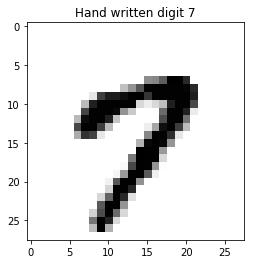

In [4]:
# Show image number 15, and write in the title what digit it should correspond to
N=15
imshow(x_train[N], cmap='gray_r')
_ = title('Hand written digit '+str(y_train[N]))

In [5]:
# Norms functions 
def dinfty(a,b):
    return np.max(np.abs(b - a))

def done(a,b):
    return np.sum(np.abs(b - a))

def dtwo(a,b):
    return sqrt(np.sum((b - a)**2))

# Function to calculate the distance "dist" for a given set of images of size N
def distMat(N, dist):
    D = np.zeros((N,N))
    for i in range(N):
        # Diagonal always equal to 0
        for j in range(i): 
            D[i][j] = dist(x_train[i], x_train[j])
    # Exploit symmetry
    return D + D.T


In [6]:
# Leave one out error
def error_rate(D,N):
    error_counter = 0
    # Diagonal can be skipped
    np.fill_diagonal(D, 1000)
    for i in range(N):
        j = argmin(D[i])  
        if y_train[i] != y_train[j]:
            error_counter+=1
    np.fill_diagonal(D, 0)        
    return error_counter/N

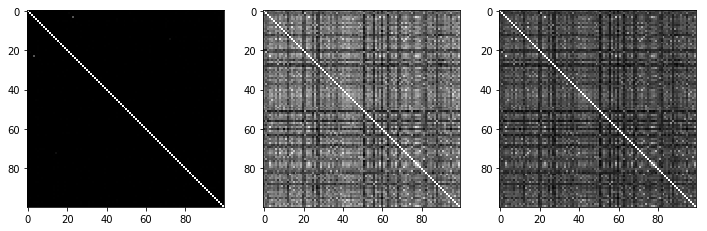

In [7]:
N = 100
# Calculate distance matrices
InfMat = distMat(N,dinfty)
OneMat = distMat(N,done)
TwoMat = distMat(N,dtwo)

# Plot them
fig=plt.figure(figsize=(12, 12))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(InfMat,cmap='gray_r')
fig.add_subplot(rows, columns, 2)
plt.imshow(OneMat,cmap='gray_r')
fig.add_subplot(rows, columns, 3)
plt.imshow(TwoMat,cmap='gray_r')
plt.show()



In [8]:
# Precalculate distance matrices
N = 1600

InfMat = distMat(N,dinfty)
OneMat = distMat(N,done)
TwoMat = distMat(N,dtwo)

In [9]:
# Calculate leave one out error
err_matrix = np.zeros((5,3))
for i in range(5):
    N = 100*2**i
    err_matrix[i][0] = error_rate(InfMat[:N, :N],N)
    err_matrix[i][1] = error_rate(OneMat[:N, :N],N)
    err_matrix[i][2] = error_rate(TwoMat[:N, :N],N)

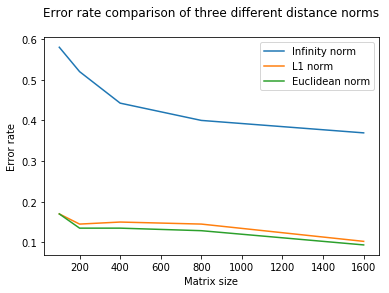

In [10]:
# Plot error rate vs N
NS = [100, 200, 400, 800, 1600]    
plot(NS, err_matrix)
_ = legend(["Infinity norm","L1 norm","Euclidean norm"])
_ = xlabel("Matrix size")
_ = ylabel("Error rate")
_ = title("Error rate comparison of three different distance norms\n")

In [11]:
print(err_matrix)

[[0.58     0.17     0.17    ]
 [0.52     0.145    0.135   ]
 [0.4425   0.15     0.135   ]
 [0.4      0.145    0.12875 ]
 [0.369375 0.1025   0.09375 ]]


In [12]:
# Normalise single image with integral
def coeff_calc_single(f1):
    a = f1/sum(f1)
    return a

# Calculate the gradient of a single image
def grad_calc(img):
    grad = np.gradient(img)  
    return grad

# Normalise set of images with integral
def coeff_calc_N(N, x_train):
    x_train_norm = np.zeros((N,28,28))
    for i in range(N):
        x_train_norm[i] = coeff_calc_single(x_train[i])
    return x_train_norm

# Calculate the gradient of a set of normalised images
def gradient_N(N, x_train_norm):
    x_train_grad = np.zeros((N,2,28,28))
    for i in range(N):
        x_train_grad[i] = grad_calc(x_train_norm[i])
    return x_train_grad


In [13]:
# H1 norm function
def dH1(grad,norm, N):
    H1Mat = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            diff1D_grad = grad[i][0]-grad[j][0]
            diff2D_grad = grad[i][1]-grad[j][1]
            diff1D_grad = np.abs(diff1D_grad)**2
            diff2D_grad = np.abs(diff2D_grad)**2
            diff1D = norm[i]-norm[j]
            diff1D = diff1D**2
            integral = np.sum(diff1D_grad + diff2D_grad+diff1D)
            H1Mat[i][j] = np.sqrt(integral)
    H1Mat = H1Mat+H1Mat.T
    return  H1Mat 

In [14]:
# Precompute normalised images and gradients
N = 1600
x_train_norm = coeff_calc_N(N, x_train[:N])
x_train_grad = gradient_N(N, x_train_norm[:N])

In [15]:
# Increase the error matrix of 1 column
err_matrix = np.hstack((err_matrix,np.zeros((5,1))))

In [16]:
# Calculate error rate
for i in range(5):
    N = 100*(2**i)
    H1Mat = dH1(x_train_grad[:N],x_train_norm[:N],N)
    err_matrix[i][3] = error_rate(H1Mat,N)

In [17]:
print(err_matrix)

[[0.58     0.17     0.17     0.23    ]
 [0.52     0.145    0.135    0.175   ]
 [0.4425   0.15     0.135    0.145   ]
 [0.4      0.145    0.12875  0.12125 ]
 [0.369375 0.1025   0.09375  0.099375]]


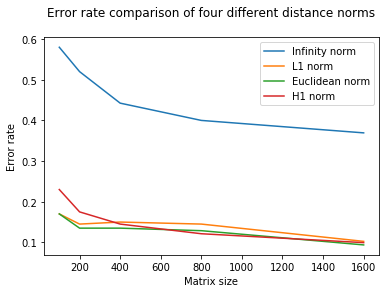

In [18]:
NS = [100, 200, 400, 800, 1600]   
plot(NS, err_matrix)
_ = legend(["Infinity norm","L1 norm","Euclidean norm", "H1 norm"])
_ = xlabel("Matrix size")
_ = ylabel("Error rate")
_ = title("Error rate comparison of four different distance norms\n")

In [19]:
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import splu

In [20]:
# Build Laplacian Matrix
def laplacian(N):
    lap = diags([1,1,-4,1,1],[-N,-1,0,1,N], shape = (N*N,N*N)).toarray()
    for i in range(0,N*N,N): lap[i,i-1] = 0
    for i in range(0,N*N,N): lap[i-1,i] = 0 
    return lap

# Calculate phi by solving the system with boundary conditions
def solve_LU(diff, lu_mat):
    size = len(diff)
    phi = zeros((size,size))
    diff_vec = diff[1:-1, 1:-1].ravel()
    phi[1:-1, 1:-1] = lu_mat.solve(diff_vec).reshape((size - 2, size - 2))
    return phi

# Calculate phi for a given N
def phiN(N, x_train_norm, lu_solver):
    phi = np.zeros((N,28,28))
    for i in range(N):
        for j in range(N):
            diff = x_train_norm[i] - x_train_norm[j]
            phi[i] = solve_LU(diff, lu_solver)
    return phi        
# Calculate the gradient of phi for a given N
def phi_gradN(N, phi):
    phi_grad = np.zeros((N,2,28,28))
    for i in range(N):
        phi_grad[i] = np.gradient(phi[i])
    return phi_grad  
        
# Calculates distance matrix on precalculated data
def distMat_opt(dist, N, data, grad): 
    distMat = np.zeros((N,N))
    for i in range(N):
        for j in range(i):
            distMat[i][j] = dmongamp(data[i], data[j], grad[i], grad[j])
    distMat = distMat+distMat.T
    return distMat
        
# Monge Ampere norm on precalculated data     
def dmongamp(a,b,phi_grada,phi_gradb):
    diff1 = phi_grada[0]-phi_gradb[0]
    diff2 = phi_grada[1]-phi_gradb[1]
    phi_grad_sq = np.abs(diff1)**2 + np.abs(diff2)**2
    toReturn = np.sum((a + b) * phi_grad_sq)
    return toReturn


In [21]:
N = 1600
mongeamp_matrix = np.zeros((5,1))
err_mongeamp = np.zeros((5,1))

# Calculate laplacian matrix
lap = laplacian(26)

# Improve performance using  a compressed sparse matrix
sparse_lap = csc_matrix(lap * (-1))

# Calculate the LU decomposition of the sparse matrix 
lu_solver = splu(sparse_lap)

# Calculate phi for a given N
phi = phiN(N, x_train_norm[:N], lu_solver)

# Calculate the gradient of phi for a given N
phi_grad = phi_gradN(N, phi[:N])

In [22]:
# Increase the error matrix of 1 column
err_matrix = np.hstack((err_matrix,np.zeros((5,1))))

In [23]:
# Calculate error rate 
for i in range(5):
        N = 100*2**i
        mongeamp_matrix = distMat_opt(dmongamp, N, x_train_norm, phi_grad)
        err_matrix[i][4] = error_rate(mongeamp_matrix,N)

In [24]:
print(err_matrix)

[[0.58     0.17     0.17     0.23     0.24    ]
 [0.52     0.145    0.135    0.175    0.2     ]
 [0.4425   0.15     0.135    0.145    0.145   ]
 [0.4      0.145    0.12875  0.12125  0.12875 ]
 [0.369375 0.1025   0.09375  0.099375 0.12125 ]]


[[0.58     0.17     0.17     0.23     0.24    ]
 [0.52     0.145    0.135    0.175    0.2     ]
 [0.4425   0.15     0.135    0.145    0.145   ]
 [0.4      0.145    0.12875  0.12125  0.12875 ]
 [0.369375 0.1025   0.09375  0.099375 0.12125 ]]


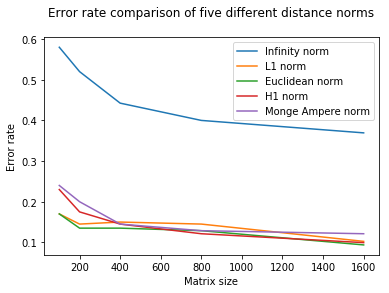

In [25]:
NS = [100, 200, 400, 800, 1600]   
print(err_matrix)
plot(NS, err_matrix)
_ = legend(["Infinity norm","L1 norm","Euclidean norm", "H1 norm", "Monge Ampere norm"])
_ = xlabel("Matrix size")
_ = ylabel("Error rate")
_ = title("Error rate comparison of five different distance norms\n")